{"message":"You are not subscribed to this API."}


## What Model ?
- Heirachial clustering:
    - Geospatial 


In [311]:
import requests
import pandas as pd
#from lxml import html
import csv 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import os 
os.chdir("/Users/tylerbrown/Desktop/github/ML Application")

In [319]:
link = pd.read_csv("Book2.csv")['Key Numbers'][2]
api_key = pd.read_csv("Book2.csv")['Key Numbers'][1]
host = pd.read_csv("Book2.csv")['Key Numbers'][0]

In [320]:
#Search String
pd.set_option('display.max_columns', None)
city = 'Boston'
state = 'MA'
search_str = city + ', ' +state
print('Search string:', search_str)


#API for For Sale
url = link
querystring = {"location":search_str}

headers = {
    'x-rapidapi-host': host,
    'x-rapidapi-key': api_key
    }
response = requests.request("GET", url, headers=headers, params=querystring)
json = response.json()
df = pd.json_normalize(data=json['props'])

Search string: Boston, MA


In [322]:
#####################
#API recently sold
#####################
url = link

querystring = {"location":search_str ,"status":"recentlySold"}

headers = {
	"X-RapidAPI-Key":api_key,
	"X-RapidAPI-Host": host
}

response1 = requests.request("GET", url, headers=headers, params=querystring)
json1 = response1.json()
historical = pd.json_normalize(data=json1['props'])

# Testing Collinearity 

/var/folders/d5/yv3yty4s3y33ty4r_pc546j80000gn/T/ipykernel_20350/1426562946.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/d5/yv3yty4s3y33ty4r_pc546j80000gn/T/ipykernel_20350/1426562946.py:8: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



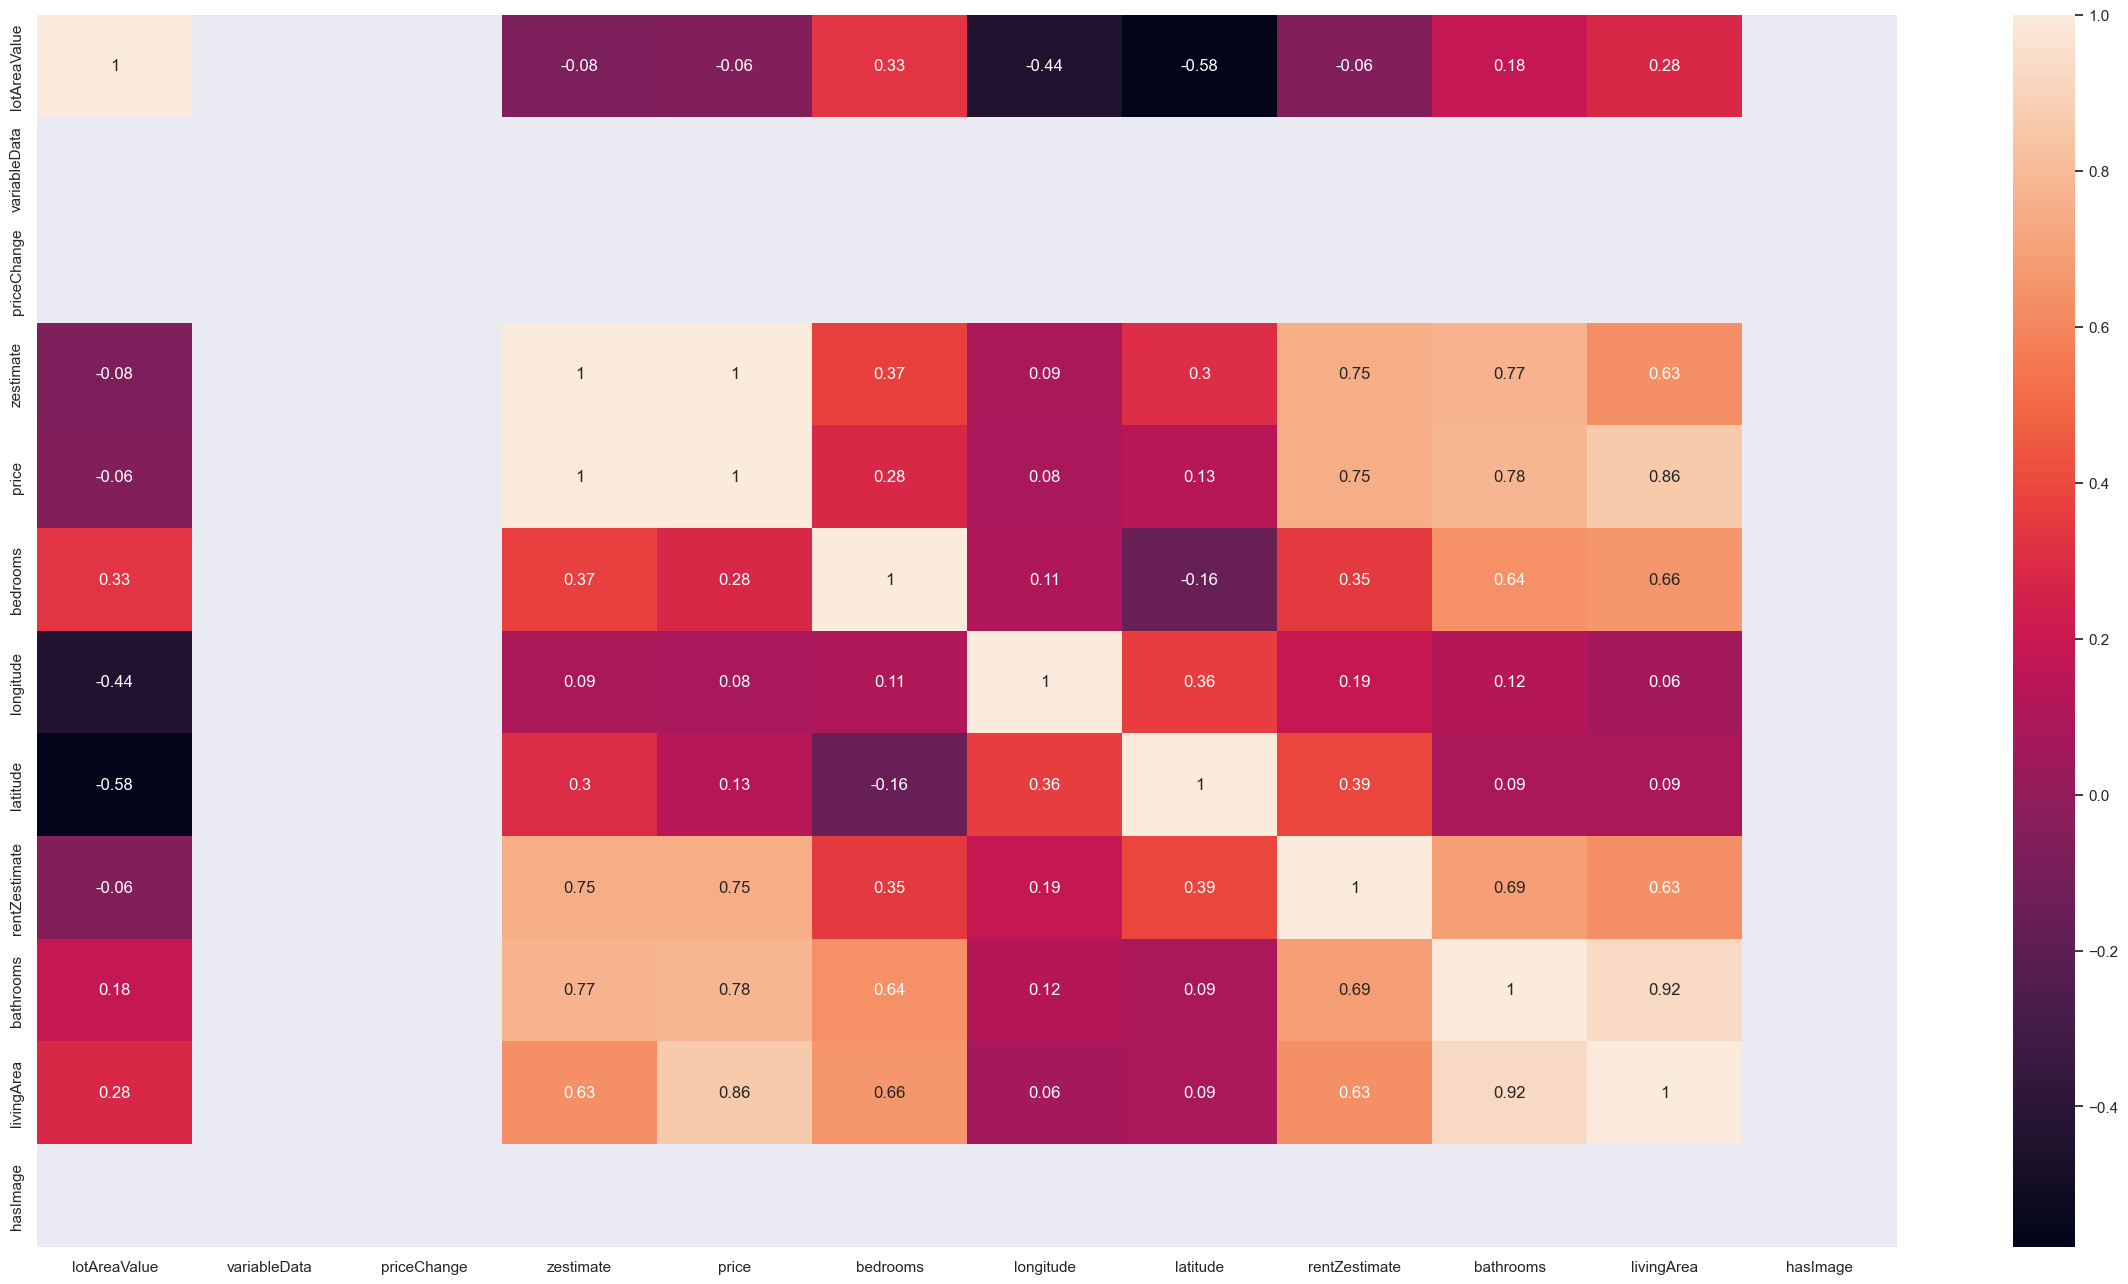

In [86]:
#Pearson correlation matrix examing r^2
matrix = df.corr(
    method = 'pearson',  # The method of correlation
    min_periods = 1      # Min number of observations required
)
sns.set(rc={'figure.figsize':(30,16)})
#Correlation Heat Map 
matrix = df.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [87]:
corr_matrix = df.corr()

# Check for correlations greater than 0.8 or less than -0.8
high_corr = np.where(corr_matrix.abs() > 0.8)
high_corr = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr) if x != y and x < y]

if high_corr:
    print("Highly correlated variables:", high_corr)
else:
    print("No highly correlated variables found.")


Highly correlated variables: [('zestimate', 'price'), ('price', 'livingArea'), ('bathrooms', 'livingArea')]


/var/folders/d5/yv3yty4s3y33ty4r_pc546j80000gn/T/ipykernel_20350/4024075721.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



# Clustering Geo-Spatial 
### Data Taken In 
- longitude
- latitude
- propertyType

Objective: Cluster on the geospatial area based on property type. This will give us groups of properties with similiar characteristics to run a linear regression task on. 

In [282]:
#########################################################
#HEIRARCHY CLUSTERING
######################################
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
# Define a function to perform hierarchical clustering and identify subclusters
def hierarchical_clustering(df):
    # Perform hierarchical clustering on the full dataset
    distances = pdist(df)
    clusters = fcluster(linkage(distances, method='ward'), .10, criterion='distance')
    df['cluster'] = clusters
    
    # Loop over each cluster and perform hierarchical clustering to identify subclusters
    for cluster_label in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster_label][['latitude', 'longitude']]
        if len(cluster_data) > 1:
            distances = pdist(cluster_data)
            subclusters = fcluster(linkage(distances, method='ward'), 0.10, criterion='distance')
            df.loc[df['cluster'] == cluster_label, 'subcluster'] = subclusters
        else:
            df.loc[df['cluster'] == cluster_label, 'subcluster'] = 1
    
    return df

# Call the function and print the results
result = hierarchical_clustering(df[['longitude', 'latitude']].dropna())


#################################################################################
#Dataframe (result) then gets called down to see the clusters and how they map out 
#################################################################################
import plotly.express as px

# Create a scatter plot of the latitude and longitude coordinates, colored by cluster
fig = px.scatter_mapbox(result, lat="latitude", lon="longitude", color="cluster",
                        zoom=10, height=600, size_max=15)

# Update the map layout to use Mapbox
fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=10, 
                  mapbox_center_lat = result['latitude'].mean(),
                  mapbox_center_lon = result['longitude'].mean())

# Show the map
fig.show()


# Linear Regression 
- Simple linear regression on sqft and price
- Has to loop through each cluster 
- Once data is parsed through the first loop then the nested loop predicts the prices


In [278]:
####################################
######Linear Regression Model#######
####################################
df[list(result.columns)] = result.dropna()

import pandas as pd
from sklearn.linear_model import LinearRegression
for cluster in list(df.cluster.unique()):
    data = df[df['cluster']== cluster]
    
    # Check if data subset is empty
    if data.empty:
        continue
    
    # Define predictor and response variables
    X = data[['livingArea']]
    y = data['price']

    # Create a linear regression object
    model = LinearRegression()

    # Fit the model to the data
    model.fit(X, y)

    # Make predictions and print results
    for i,sqft in enumerate(data.livingArea):
        try:
            print("Cluster:", cluster)
            new_observation = [[sqft]]  # Predict the price for a house with 2000 square feet of living area
            print("Square footage: ", sqft)
            print("Actual Price:",data.price[i])
            print('predicted:' ,abs(model.predict(new_observation))[0])
        except:
            pass


Cluster: 4.0
Square footage:  1060
Actual Price: 338226
predicted: 971937.2583657998
Cluster: 4.0
Square footage:  3427
Cluster: 4.0
Square footage:  561
Cluster: 4.0
Square footage:  2668
Cluster: 4.0
Square footage:  1245
Actual Price: 950000
predicted: 1018272.0058054427
Cluster: 4.0
Square footage:  1200
Cluster: 4.0
Square footage:  1107
Cluster: 4.0
Square footage:  1044
Cluster: 4.0
Square footage:  1699
Cluster: 4.0
Square footage:  521
Cluster: 4.0
Square footage:  760
Cluster: 4.0
Square footage:  1660
Actual Price: 699000
predicted: 1122212.1149268039
Cluster: 4.0
Square footage:  1252
Actual Price: 1300000
predicted: 1020025.2124653211
Cluster: 4.0
Square footage:  387
Actual Price: 799000
predicted: 803378.960923207
Cluster: 4.0
Square footage:  1494
Actual Price: 1175000
predicted: 1080636.0712782594
Cluster: 3.0
Square footage:  3242
Cluster: 3.0
Square footage:  938
Actual Price: 799000
predicted: 588849.3027205319
Cluster: 3.0
Square footage:  2200
Cluster: 3.0
Square 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted 

# Random Forest Model 
- Taking in discrete variables
 - bathrooms
 - bedrooms
 - Price (Target (continous - may have to bin to improve model?))
 - Cluster (Serves as a geo-predictor)

In [324]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset

# Select the columns you want to include in your decision tree
features = ['bathrooms', 'bedrooms', 'cluster']
target = 'price'
decision_tree = df[features + [target]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(decision_tree[features], 
                                                    decision_tree[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

# drop missing values from the training set
X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]

# drop missing values from the testing set
X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]

# Create a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Custom input values
bathrooms = 4
bedrooms = 5

# Create a dictionary of custom input values
input_dict = {'bathrooms': [bathrooms], 
              'bedrooms': [bedrooms], 
              'cluster': [3]} # You need to specify a cluster value here

# Convert the dictionary to a pandas DataFrame
X_custom = pd.DataFrame.from_dict(input_dict)

# Make a prediction on the custom input values
y_pred_custom = rf_model.predict(X_custom)

# Print the predicted price
print(f"The predicted price for a property with {bathrooms} bathrooms and {bedrooms} bedrooms is ${y_pred_custom[0]:,.2f}")


The predicted price for a property with 4 bathrooms and 5 bedrooms is $1,309,619.00


In [287]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load the dataset
def randomforest(df, bd, br, clust):
    # Select the columns you want to include in your decision tree
    features = ['bathrooms', 'bedrooms', 'cluster']
    target = 'price'
    decision_tree = df[features + [target]]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(decision_tree[features], 
                                                        decision_tree[target], 
                                                        test_size=0.2, 
                                                        random_state=42)

    # drop missing values from the training set
    X_train.dropna(inplace=True)
    y_train = y_train.loc[X_train.index]

    # drop missing values from the testing set
    X_test.dropna(inplace=True)
    y_test = y_test.loc[X_test.index]

    # Create a random forest regression model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model on the training data
    rf_model.fit(X_train, y_train)

    # Custom input values
    bathrooms = 4
    bedrooms = 5

    # Create a dictionary of custom input values
    input_dict = {'bathrooms': [br], 
                'bedrooms': [bd], 
                'cluster': [clust]} # You need to specify a cluster value here

    # Convert the dictionary to a pandas DataFrame
    X_custom = pd.DataFrame.from_dict(input_dict)

    # Make a prediction on the custom input values
    y_pred_custom = rf_model.predict(X_custom)

    # Print the predicted price
    print(f"The predicted price for a property with {bathrooms} bathrooms and {bedrooms} bedrooms is ${y_pred_custom[0]:,.2f}")



In [295]:
df.columns

Index(['dateSold', 'propertyType', 'lotAreaValue', 'address', 'variableData',
       'priceChange', 'zestimate', 'imgSrc', 'price', 'unit', 'bedrooms',
       'contingentListingType', 'longitude', 'latitude', 'listingStatus',
       'zpid', 'rentZestimate', 'daysOnZillow', 'bathrooms', 'livingArea',
       'country', 'currency', 'lotAreaUnit', 'hasImage',
       'listingSubType.is_FSBA', 'variableData.text', 'variableData.type',
       'listingSubType.is_openHouse', 'newConstructionType',
       'listingSubType.is_newHome', 'cluster', 'subcluster'],
      dtype='object')

In [293]:
for i in 
    randomforest(df,2,6,4)

The predicted price for a property with 4 bathrooms and 5 bedrooms is $1,821,931.32
